<a href="https://colab.research.google.com/github/JScottLopez/mlb/blob/main/MLB_Pitch_Types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: MLB Pitch Classification

Authored By: Joseph Scott Lopez
Date: 8/19/2022

Description:

This notebook compares two classification algorithms using pitching data from MLB pitcher Joe Musgrove. The first is the Naive Bayes algorithm followed by K-Means Clustering.


In [ ]:
#Install necessary packages
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

packnames = ('moments','ggpubr','NbClust','factoextra','caret','e1071')

from rpy2.robjects.vectors import StrVector

names_to_install = [x
   for x in packnames
   if not rpackages.isinstalled(x)
]
if len(names_to_install) > 0:
   utils.install_packages(StrVector(names_to_install))

%load_ext rpy2.ipython

(as ‘lib’ is unspecified)







































































































































In [25]:
#Import dataset
%%R
library(readr);
Joe_Musgrove <- read_csv("Joe_Musgrove.csv")

New names:
• `vs Avg` -> `vs Avg...8`
• `vs Avg` -> `vs Avg...11`
Rows: 41 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Pitch, Team, Hand
dbl (9): Year, #, MPH, Inches of Drop, vs Avg...8, % vs Avg, Inches of Break...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
%%R
head(Joe_Musgrove)

# A tibble: 6 × 12
   Year Pitch    Team  Hand    `#`   MPH Inche…¹ vs Av…² % vs …³ Inche…⁴ vs Av…⁵
  <dbl> <chr>    <chr> <chr> <dbl> <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
1  2016 Changeup  HOU  R        82  82.9    36.7     7.1      24    10.5    -2  
2  2016 Curveba…  HOU  R        77  78.6    59.7     5.9      11     9.4     3.1
3  2016 4-Seamer  HOU  R       396  92.4    19.4    -5.4     -38     4.4    -3.6
4  2016 Sinker    HOU  R        75  90.6    27.6     7.4      37    10.9    -3  
5  2016 Slider    HOU  R       349  82.3    43.8     6.5      18    11.8     7.5
6  2017 Slider    HOU  R       484  83.2    42.1     4.7      12     9.8     4.7
# … with 1 more variable: `% Break vs Avg` <dbl>, and abbreviated variable
#   names ¹​`Inches of Drop`, ²​`vs Avg...8`, ³​`% vs Avg`, ⁴​`Inches of Break`,
#   ⁵​`vs Avg...11`
# ℹ Use `colnames()` to see all variable names


In [27]:
%%R
#Assign values to system variables and check for N/A's and if they are numeric
mph<-Joe_Musgrove$MPH;
inches_drop<-Joe_Musgrove$'Inches of Drop'
inches_break<-Joe_Musgrove$'Inches of Break'

In [28]:
%%R
#Calculate descriptive statistics for mph
summary(mph)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  78.60   82.90   87.10   87.29   92.00   93.50 


In [29]:
%%R
summary(inches_drop)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.40   25.20   31.50   33.71   41.50   59.70 


In [30]:
%%R
summary(inches_break)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.500   5.200   9.400   8.346  11.000  14.000 


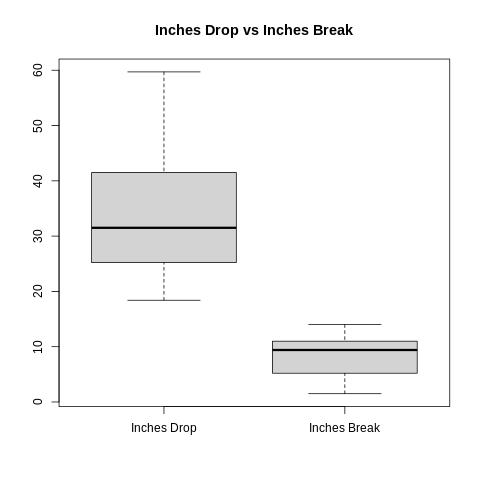

In [31]:
%%R
boxplot(inches_drop,inches_break, main="Inches Drop vs Inches Break", names=c("Inches Drop","Inches Break"))

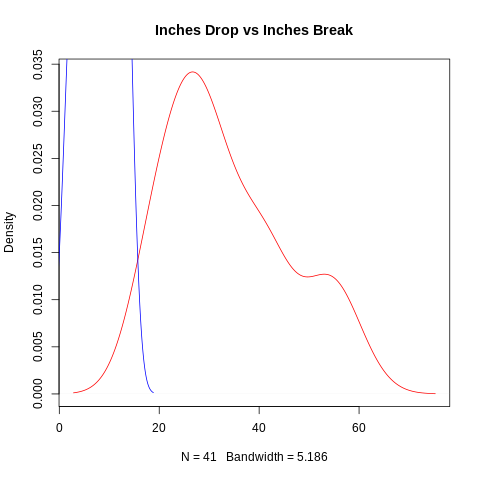

In [32]:
%%R
inches_drop_d<-density(inches_drop)
inches_break_d<-density(inches_break)
plot(inches_drop_d, col='red', main="Inches Drop vs Inches Break")
lines(inches_break_d, col='blue')

In [33]:
%%R
df<-Joe_Musgrove
df$Pitch<-as.factor(df$Pitch)
str(df)

spec_tbl_df [41 × 12] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Year           : num [1:41] 2016 2016 2016 2016 2016 ...
 $ Pitch          : Factor w/ 6 levels "4-Seamer","Changeup",..: 2 3 1 5 6 6 2 1 5 4 ...
 $ Team           : chr [1:41] " HOU" " HOU" " HOU" " HOU" ...
 $ Hand           : chr [1:41] "R" "R" "R" "R" ...
 $ #              : num [1:41] 82 77 396 75 349 484 170 713 143 83 ...
 $ MPH            : num [1:41] 82.9 78.6 92.4 90.6 82.3 83.2 84.3 93.1 91.6 90.4 ...
 $ Inches of Drop : num [1:41] 36.7 59.7 19.4 27.6 43.8 42.1 33.8 18.5 27.6 25.6 ...
 $ vs Avg...8     : num [1:41] 7.1 5.9 -5.4 7.4 6.5 4.7 5.3 -4.4 7.1 -2.2 ...
 $ % vs Avg       : num [1:41] 24 11 -38 37 18 12 18 -31 35 -9 ...
 $ Inches of Break: num [1:41] 10.5 9.4 4.4 10.9 11.8 9.8 13 6.2 13.1 1.6 ...
 $ vs Avg...11    : num [1:41] -2 3.1 -3.6 -3 7.5 4.7 -0.3 -1.5 -1.3 -0.3 ...
 $ % Break vs Avg : num [1:41] -16 49 -45 -21 176 93 -2 -20 -9 -14 ...
 - attr(*, "spec")=
  .. cols(
  ..   Year = col_double(),
  .

In [34]:
%%R
df <- df[-c(1,3,4,5,8,9,11,12)]
df

# A tibble: 41 × 4
   Pitch       MPH `Inches of Drop` `Inches of Break`
   <fct>     <dbl>            <dbl>             <dbl>
 1 Changeup   82.9             36.7              10.5
 2 Curveball  78.6             59.7               9.4
 3 4-Seamer   92.4             19.4               4.4
 4 Sinker     90.6             27.6              10.9
 5 Slider     82.3             43.8              11.8
 6 Slider     83.2             42.1               9.8
 7 Changeup   84.3             33.8              13  
 8 4-Seamer   93.1             18.5               6.2
 9 Sinker     91.6             27.6              13.1
10 Cutter     90.4             25.6               1.6
# … with 31 more rows
# ℹ Use `print(n = ...)` to see more rows


In [35]:
%%R
pitch_clust<-Joe_Musgrove[,c(6,7,10)]
df<-scale(pitch_clust)
fviz_nbclust(pitch_clust,kmeans,method=c("silhouette","wss","gap_stat"))

  could not find function "fviz_nbclust"




Error in fviz_nbclust(pitch_clust, kmeans, method = c("silhouette", "wss",  : 
  could not find function "fviz_nbclust"


RInterpreterError: ignored

In [21]:
%%R
library(e1071)
model=naiveBayes(train$Pitch~.,train)
model


Error in library(e1071) : there is no package called ‘e1071’


RInterpreterError: ignored